# Training pytorch.ResNet on a tiny-imagenet-200 dataset using Tensorboard on google collab's GPU

In [ ]:
import pandas as pd
from pathlib import Path
from pandas import DataFrame
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as t
from functools import lru_cache
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import datetime
from google.colab import output
from tensorflow import summary 
%load_ext tensorboard

To train the network, it needs to feed data at each iteration. For a classification problem, this is usually a tensor-a picture and a class number. These images are also read from the disk and some preprocessing is performed.

This logic must be implemented in a custom class inherited from torch.utils. data.Dataset. The __getitem__ and __len__ methods are required for implementation.

In [ ]:
class TinyImagenetDataset(Dataset):
    def __init__(self, dataframe: DataFrame):
        self._df = dataframe
        self._transform = t.Compose([t.ToTensor(),
                            t.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    def __getitem__(self, idx: int):
        path, label = tuple(self._df.loc[idx, :])
        image = _get_image(path)
        image = self._transform(image)
        return image, classes.index(label)

    def __len__(self):
        return len(self._df)

@lru_cache(maxsize=2**17)
def _get_image(path: Path) -> Image:
    image = Image.open(path).convert("RGB")
    return image


def define_model(model='resnet18', dropout=0, pretrained=True):
    if model == 'resnet18':
        model = torchvision.models.resnet18(pretrained=pretrained)  
    elif model == 'resnet34':
        model = torchvision.models.resnet34(pretrained=pretrained)
        return model
        pass
    else:
        raise ValueError('Unsupported type net')
    inp_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(inp_features, num_classes))
    return model

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    summary.image('my_image', img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# functions to show an example of batch
def show_batch(model ,trainloader):
    dataiter = iter(trainloader)
    example_data = dataiter.next()
    images, label = example_data
    imshow(torchvision.utils.make_grid(images))

def training(model, trainloader, stat, num_epoch=1, lr=0.001):
    print('Start Training')
    start_time = time.perf_counter()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    running_loss = 0.0
    running_correct = 0
    n_total_step = len(trainloader)
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # labels = torch.tensor(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            if dev == 'TPU':
              xm.optimizer_step(optimizer, barrier=True)
            else:
              optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # predicted = predicted.to(device)
            running_correct += (predicted == labels).sum().item()
            if i % stat == (stat - 1):  
              with train_summary_writer.as_default():
                summary.scalar('train_loss', running_loss / stat, epoch * n_total_step + i)
                summary.scalar('traning_accuracy', running_correct * 100 / (stat * len(labels)), epoch * n_total_step + i)
              # summary.scalar('accuracy_score', accuracy_score(labels, predicted, normalize=False), epoch * n_total_step + i)
              # print(f'on iteration №{epoch * n_total_step + i + 1} loss was {round(running_loss / stat, 3)} and total accuracy was {running_correct * 100 / (stat * 50)}%')
              running_loss = 0.0
              running_correct = 0
    end_time = time.perf_counter()
    print('Finished Training')
    duration_in_seconds = end_time - start_time 
    print(f'Duration of training was: {round(duration_in_seconds / 60, 1)} min (Epoch: {num_epoch}, batch size: {len(labels)})')

def testing(model, testloader, stat):
    running_correct = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    count = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            if count % stat == (stat - 1):  
              with train_summary_writer.as_default():
                summary.scalar('test_accuracy', running_correct * 100 / (stat * len(labels)), count)
                running_correct = 0
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            count +=1
    count = 0
    for clc in class_total:
        if clc == 0:
            class_total[count] = 0.000001
        count += 1

    dict_for_clc = dict()
    for i in range(200):
        dict_for_clc[labels_clc[classes[i]]] = 100 * class_correct[i] / class_total[i]
    list_dict = list(dict_for_clc.items())
    list_dict.sort(key=lambda i: i[1])
    print('#' * 100)
    print('Top 10 best')
    for i in range(10):
        a = list_dict[-(i + 1)]
        print('Accuracy of %5s: %2d %%'% (a[0], a[1]))
    print('#' * 100)
    print('Top 10 worst')
    for i in range(10):
        a = list_dict[i]
        print('Accuracy of %5s: %2d %%'% (a[0], a[1]))

Download, unpack, and process the dataset. Since the test subset is not marked up, we use the validation subset instead.

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

data_dir = Path(r'tiny-imagenet-200')

labels_clc = pd.read_csv(data_dir / 'words.txt', sep="\t",
                  header=None, index_col=0)[1].to_dict()
classes = [line.strip() for line in open(data_dir / 'wnids.txt')]
num_classes = len(classes)

train_set = pd.DataFrame({'0': [], '1': []})
for cls in classes:
    df = pd.read_csv(data_dir / 'train' / str(cls) / (str(cls) + '_boxes.txt'), sep="\t",
                     header=None)
    df.drop(df.columns[[1, 2, 3, 4]], axis=1, inplace=True)
    for i in range(len(df)):
        df.loc[i, 1] = str(cls)
        df[0][i] = (data_dir / 'train' / str(cls) / 'images' / df[0][i])
    train_set = pd.concat([train_set, df], ignore_index=True, axis=0)
train_set.drop(train_set.columns[[2, 3]], axis=1, inplace=True)

# train_set.to_csv(data_dir / 'train_set.csv', index=False)
# train_set = pd.read_csv(data_dir / 'train_set.csv')

df = pd.read_csv(data_dir / 'val' / 'val_annotations.txt', sep="\t", header=None)
df.drop(df.columns[[2, 3, 4, 5]], axis=1, inplace=True)
for i in range(len(df)):
    df[0][i] = data_dir / 'val' / 'images' / df[0][i]
test_set = df
output.clear()

Run this command to display the tensorboard

In [ ]:
%tensorboard --logdir logs/tensorboard

Let's start learning

program calculate on GPU


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


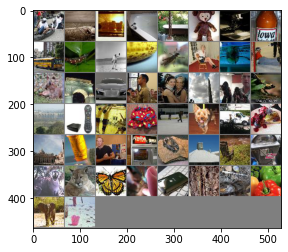

Start Training
Finished Training
Duration of training was: 2.3 min (Epoch: 1, batch size: 50)


NameError: ignored

In [ ]:
log_dir = Path(r'C:\image_classification')
arch = 'resnet18'
dev = 'GPU'
num_batch = 50
prob_drop = 0
lr = 0.001
num_epoch = 1
stat = 5 # how often do you want to see statistics
pretrain = True

trainset = TinyImagenetDataset(train_set)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=num_batch, shuffle=True, num_workers=0)
testset = TinyImagenetDataset(test_set)
testloader = torch.utils.data.DataLoader(testset, batch_size=num_batch, shuffle=False, num_workers=0)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  dev = 'GPU'
elif dev == 'TPU':
  !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl
  import torch_xla
  import torch_xla.core.xla_model as xm
  device = xm.xla_device()
  dev = 'TPU'
  output.clear()
else:
  device = torch.device('cpu')
  dev = 'CPU'
print('program calculate on ' + dev)

current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

model = define_model(model=arch, dropout=prob_drop, pretrained=pretrain).to(device)

show_batch(model, testloader)

training(model, trainloader, stat, num_epoch=num_epoch, lr=lr)

testing(model, testloader, 1)